## Imports and variables

In [53]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np
import io
import csv
import glob
import re
import copy

In [40]:
train_file_info = {
    "../training_log_2025-08-07_23:03:48.084741.csv": "Delta = 10",
    "../training_log_2025-08-07_23:05:19.429531.csv": "Delta = 1",
    "../training_log_2025-08-07_23:09:20.350141.csv": "Delta = 0.1"
}
val_file_info = {
    "../validation_log_2025-08-07_23:03:48.086008.csv": "Delta = 10",
    "../validation_log_2025-08-07_23:05:19.431228.csv": "Delta = 1",
    "../validation_log_2025-08-07_23:09:20.351236.csv": "Delta = 0.1"
}
all_expected_columns = ["Mode", "Epoch", "Total Loss", "Cross Entropy Loss","KL Div","KL Div * Beta","Reg Loss", "Reg Loss * Gamma", 
                        "Length Pred Acc", "Length Loss [mae]", "Token Pre Acc", "Amino Acc", "Empty Acc", 
                        "MAE length", "MAE charge", "MAE hydrophobicity moment", 
                        "Interpretability - length", "Interpretability - charge", "Interpretability - hydrophobicity moment",
                        "Corr_score - length", "Corr_score - charge", "Corr_score - hydrophobicity moment",
                        "Modularity - length", "Modularity - charge", "Modularity - hydrophobicity moment",
                        "MIG - length", "MIG - charge", "MIG - hydrophobicity moment",
                        "SAP_score - length", "SAP_score - charge", "SAP_score - hydrophobicity moment"] 
models_prefixs_to_compare = [
    "hyperparams_tuning_factor_10_ar-vae_epoch",
    "hyperparams_tuning_factor_1_ar-vae_epoch",
    "hyperparams_tuning_ar-vae_epoch"
]

column_a = 'Epoch'

### Functions

In [89]:
def find_files_with_matching_epochs(grouped_files):
    """
    Znajduje pliki z tym samym numerem epoki i grupuje je według sufiksu.

    Args:
        grouped_files (dict): Zagnieżdżony słownik z prefiksami, sufiksami i listą plików.
    
    Returns:
        dict: Słownik z kluczem epoki.
    """
    epochs_to_files = {}

    for prefix, groups in grouped_files.items():
        for suffix, file_list in groups.items():
            for filename in file_list:
                # Używamy wyrażenia regularnego, aby znaleźć numer epoki
                match = re.search(r'epoch(\d+)', filename)
                if match:
                    epoch_number = int(match.group(1))
                    
                    if epoch_number not in epochs_to_files:
                        epochs_to_files[epoch_number] = {}
                    if prefix not in epochs_to_files[epoch_number]:
                        epochs_to_files[epoch_number][prefix] = {'_encoder': '', '_decoder': ''}
                    # print(epochs_to_files)
                    # print(f'\n')
                    # print(epoch_number)
                    # print(prefix)
                    # print(f'\n')
                    # Dodajemy plik do odpowiedniej listy na podstawie sufiksu
                    epochs_to_files[epoch_number][prefix][suffix] = filename
    
    return epochs_to_files

In [57]:
def find_and_group_model_files(prefixes_to_compare, suffixes_to_group=['_encoder', '_decoder'], directory="."):
    """
    Wyszukuje pliki .pt dla danych prefiksów i grupuje je według sufiksów.

    Args:
        prefixes_to_compare (list): Lista prefiksów do porównania.
        suffixes_to_group (list): Lista sufiksów do grupowania (np. ['_encoder', '_decoder']).
        directory (str): Ścieżka do folderu, w którym szukamy plików.
    
    Returns:
        dict: Zagnieżdżony słownik z pogrupowanymi plikami.
              Przykład: {'prefix_name': {'_encoder': [...], '_decoder': [...]}}
    """
    found_files = {}
    unique_prefixes = sorted(list(set(prefixes_to_compare)))

    for prefix in unique_prefixes:
        search_pattern = os.path.join(directory, f"{prefix}*.pt")
        all_matches = glob.glob(search_pattern)
        files_for_prefix = {suffix: [] for suffix in suffixes_to_group}

        for file_path in all_matches:
            file_name = os.path.basename(file_path)
            found = False
            for suffix in suffixes_to_group:
                if file_name.endswith(f"{suffix}.pt"):
                    files_for_prefix[suffix].append(file_name)
                    found = True
                    break
        
        found_files[prefix] = files_for_prefix
    
    return found_files

In [3]:
def read_and_fix_csv(file_path, all_expected_columns):
    """
    Wczytuje plik CSV, ręcznie uzupełnia wiersze o brakujące kolumny
    i zwraca DataFrame z danymi.
    
    Args:
        file_path (str): Ścieżka do pliku CSV.
        all_expected_columns (list): Lista nazw wszystkich oczekiwanych kolumn.
    
    Returns:
        pd.DataFrame: Naprawiony DataFrame z danymi.
    """
    if not isinstance(all_expected_columns, list):
        print("Błąd: 'all_expected_columns' musi być listą.")
        return None

    fixed_rows = []
    
    try:
        with open(file_path, 'r', newline='', encoding='utf-8') as f:
            reader = csv.reader(f)
            header = next(reader)
            num_cols_in_header = len(header)
            num_expected_cols = len(all_expected_columns)
            
            for row in reader:
                if len(row) != num_cols_in_header:
                    
                    if len(row) > num_expected_cols:
                        row = row[:num_expected_cols]
                    
                    if len(row) < num_expected_cols:
                        row.extend([None] * (num_expected_cols - len(row)))

                fixed_rows.append(row)
                
    except FileNotFoundError:
        print(f"Błąd: Plik '{file_path}' nie został znaleziony.")
        return None
    except Exception as e:
        print(f"Wystąpił nieoczekiwany błąd podczas przetwarzania pliku '{file_path}': {e}")
        return None
    
    df = pd.DataFrame(fixed_rows, columns=all_expected_columns)
    df['MAE length'] = pd.to_numeric(df['MAE length'], errors='coerce')
    df['MAE charge'] = pd.to_numeric(df['MAE charge'], errors='coerce')
    df['MAE hydrophobicity moment'] = pd.to_numeric(df['MAE hydrophobicity moment'], errors='coerce')
    df = df.fillna(0)
    
    return df

In [36]:
def convert_rgba_to_rgb(rgba):
    row, col, ch = rgba.shape
    if rgba.dtype == 'uint8':
        rgba = rgba.astype('float32') / 255.0
    if ch == 3:
        return rgba
    assert ch == 4
    rgb = np.zeros((row, col, 3), dtype='float32')
    r, g, b, a = rgba[:, :, 0], rgba[:, :, 1], rgba[:, :, 2], rgba[:, :, 3]
    a = np.asarray(a, dtype='float32')

    rgb[:, :, 0] = r * a + (1.0 - a)
    rgb[:, :, 1] = g * a + (1.0 - a)
    rgb[:, :, 2] = b * a + (1.0 - a)

    return np.asarray(rgb)

In [ ]:
def plot_dim(data1, target1, data2, target2, data3, target3, filename, dim2=1, xlim=None, ylim=None):
    attr = ['Length', 'Charge' , 'Hydrophobic moment']
    n_rows = 3
    n_cols = 3
    n_plots = n_rows * n_cols
    
    fig, axes = plt.subplots(
        nrows=n_rows,
        ncols=n_cols,
        figsize=(13, 15),
        dpi=150           
    )
    axes_flat = axes.flatten()
    min_1row = np.min(np.concatenate((target1[0,:,0], target2[0,:,0], target3[0,:,0])))
    max_1row = np.max(np.concatenate((target1[0,:,0], target2[0,:,0], target3[0,:,0])))
    min_2row = np.min(np.concatenate((target1[1,:,1], target2[1,:,1], target3[1,:,1])))
    max_2row = np.max(np.concatenate((target1[1,:,1], target2[1,:,1], target3[1,:,1])))
    min_3row = np.min(np.concatenate((target1[2,:,2], target2[2,:,2], target3[2,:,2])))
    max_3row = np.max(np.concatenate((target1[2,:,2], target2[2,:,2], target3[2,:,2])))
    axes[0,0].scatter(
                x=data1[0,:, 0],
                y=data1[0,:, dim2],
                c=target1[0,:,0],
                s=12,
                linewidths=0,
                cmap="viridis",
                alpha=0.5,
                vmin=min_1row,   # Ustawiamy globalne min/max dla kolorów
                vmax=max_1row   # Ustawiamy globalne min/max dla kolorów
    )
    axes[0,0].set_title(f'VAE', fontsize = 16)
    axes[0,0].set_xlabel(f'dimension: {attr[0]}', fontsize=14)
    axes[0,0].set_ylabel(f'not regularized dimension', fontsize=14)
    axes[0,1].scatter(
                x=data2[0,:, 0],
                y=data2[0,:, dim2],
                c=target2[0,:,0],
                s=12,
                linewidths=0,
                cmap="viridis",
                alpha=0.5,
                vmin=min_1row,   # Ustawiamy globalne min/max dla kolorów
                vmax=max_1row   # Ustawiamy globalne min/max dla kolorów
    )
    axes[0,1].set_title(f'AR-VAE', fontsize = 16)
    axes[0,1].set_xlabel(f'dimension: {attr[0]}', fontsize=14)
    axes[1,0].scatter(
                x=data1[1,:, 1],
                y=data1[1,:, dim2],
                c=target1[1,:,1],
                s=12,
                linewidths=0,
                cmap="viridis",
                alpha=0.5,
                vmin=min_2row,   # Ustawiamy globalne min/max dla kolorów
                vmax=max_2row   # Ustawiamy globalne min/max dla kolorów
    )
    # axes[1,0].set_title(f'{attr[1]} for IWAE')
    axes[1,0].set_xlabel(f'dimension: {attr[1]}', fontsize=14)
    axes[1,0].set_ylabel(f'not regularized dimension', fontsize=14)
    axes[1,1].scatter(
                x=data2[1,:, 1],
                y=data2[1,:, dim2],
                c=target2[1,:,1],
                s=12,
                linewidths=0,
                cmap="viridis",
                alpha=0.5,
                vmin=min_2row,   # Ustawiamy globalne min/max dla kolorów
                vmax=max_2row   # Ustawiamy globalne min/max dla kolorów
    )
    # axes[1,1].set_title(f'{attr[1]} for AR-VAE')
    axes[1,1].set_xlabel(f'dimension: {attr[1]}', fontsize=14)
    axes[2,0].scatter(
                x=data1[2,:, 2],
                y=data1[2,:, dim2],
                c=target1[2,:,2],
                s=12,
                linewidths=0,
                cmap="viridis",
                alpha=0.5,
                vmin=min_3row,   # Ustawiamy globalne min/max dla kolorów
                vmax=max_3row   # Ustawiamy globalne min/max dla kolorów
    )
    # axes[2,0].set_title(f'{attr[2]} for IWAE')
    axes[2,0].set_xlabel(f'dimension: {attr[2]}', fontsize=14)
    axes[2,0].set_ylabel(f'not regularized dimension', fontsize=14)
    axes[2,1].scatter(
                x=data2[2,:, 2],
                y=data2[2,:, dim2],
                c=target2[2,:,2],
                s=12,
                linewidths=0,
                cmap="viridis",
                alpha=0.5,
                vmin=min_3row,   # Ustawiamy globalne min/max dla kolorów
                vmax=max_3row   # Ustawiamy globalne min/max dla kolorów
    )
    # axes[2,1].set_title(f'{attr[2]} for AR-VAE')
    axes[2,1].set_xlabel(f'dimension: {attr[2]}', fontsize=14)
    # for i, ax in enumerate(axes_flat):
    #     ax.set_ylabel(f'not regularized dimension', fontsize=14)
    cbar_ax_0_row = fig.colorbar(
        # Użyj obiektu mappable z DOWOLNEGO wykresu w tym rzędzie,
        # ponieważ wszystkie używają tego samego cmap, vmin i vmax
        axes[0, 0].collections[0], # collections[0] to zazwyczaj obiekt Scatter
        ax=axes[0, :].ravel().tolist(), # Kluczowe: Lista osi dla pierwszego rzędu
        label='Length',
        shrink=0.8, # Zmniejsz pasek kolorów, aby lepiej pasował
        aspect=20 # Kontroluje proporcje paska kolorów
    )
    cbar_ax_0_row.ax.set_ylabel('')
    # Przykład dla drugiego rzędu (wykresy w kolumnach 0 i 1 w rzędzie 1)
    cbar_ax_1_row = fig.colorbar(
        axes[1, 0].collections[0],
        ax=axes[1, :].ravel().tolist(), # Kluczowe: Lista osi dla drugiego rzędu
        label='Charge',
        shrink=0.8,
        aspect=20
    )
    cbar_ax_1_row.ax.set_ylabel('')
    # Możesz powtórzyć to dla pozostałych rzędów (axes[2, :] i axes[3, :])
    cbar_ax_2_row = fig.colorbar(
        axes[2, 0].collections[0],
        ax=axes[2, :].ravel().tolist(), # Kluczowe: Lista osi dla trzeciego rzędu
        label='Hydrophobic moment',
        shrink=0.8,
        aspect=20
    )
    cbar_ax_2_row.ax.set_ylabel('')
    plt.savefig(filename, format='png', dpi=150)

In [ ]:
def plot_latent_surface(train_loader,filtered_models, dim1=[0], dim2=1, grid_res=0.05, z_dim = 56):
    attr = ['Length', 'Charge' , 'Hydrophobic moment']
    all_final_z_points_iwae = []
    all_final_attr_labels_iwae = []
    all_final_z_points_arvae = []
    all_final_attr_labels_arvae = []

    sorted_epochs = sorted(filtered_models.keys())
    for epoch in sorted_epochs:
        n_compare = len(filtered_models[epoch])
        for model in filtered_models[epoch]:
            model
    for d in dim1:
        dim_z_iwae = []
        dim_attr_iwae = []
        dim_z_arvae = []
        dim_attr_arvae = []
        attr_labels_all = []
        

        for batch, labels, physchem, attributes_input in train_loader: 
            peptides = batch.permute(1, 0).type(LongTensor).to(DEVICE) # S x B

            mu, std = encoder_iwae(peptides)
            z_iwae = mu.clone()
            outputs_iwae = decoder_iwae(z_iwae)
            src_iwae = outputs_iwae.permute(1, 2, 0)  # B x C x S
            src_decoded_iwae = src_iwae.argmax(dim=1) # B x S
            decoded_iwae = dataset_lib.decoded(src_decoded_iwae, "") 
            labels_iwae = dataset_lib.calculate_physchem_test(decoded_iwae)

    
            mu, std = encoder_arvae(peptides)
            z_arvae = mu.clone()
            outputs_arvae = decoder_arvae(z_arvae)
            src_arvae = outputs_arvae.permute(1, 2, 0)  # B x C x S
            src_decoded_arvae = src_arvae.argmax(dim=1) # B x S
            decoded_arvae = dataset_lib.decoded(src_decoded_arvae, "") 
            labels_arvae = dataset_lib.calculate_physchem_test(decoded_arvae)
    
                        
            dim_z_iwae.append(z_iwae.detach().cpu().numpy())
            dim_attr_iwae.append(labels_iwae.detach().cpu().numpy())
            dim_z_arvae.append(z_arvae.detach().cpu().numpy())
            dim_attr_arvae.append(labels_arvae.detach().cpu().numpy())

        dim_z_iwae = np.vstack(dim_z_iwae)
        dim_attr_iwae = np.vstack(dim_attr_iwae)
        dim_z_arvae = np.vstack(dim_z_arvae)
        dim_attr_arvae = np.vstack(dim_attr_arvae)
        
        all_final_z_points_iwae.append(dim_z_iwae)
        all_final_attr_labels_iwae.append(dim_attr_iwae)
        all_final_z_points_arvae.append(dim_z_arvae)
        all_final_attr_labels_arvae.append(dim_attr_arvae)
        
    aggregated_z_points_iwae = np.stack(all_final_z_points_iwae)
    aggregated_attr_labels_iwae = np.stack(all_final_attr_labels_iwae)
    aggregated_z_points_arvae = np.stack(all_final_z_points_arvae)
    aggregated_final_attr_labels_arvae = np.stack(all_final_attr_labels_arvae)
    save_filename = os.path.join(
            os.getcwd(),
            f'latent_surface_{dim2}dim.png'
    )
    # print(f'aggregated_z_points_iwae = {aggregated_z_points_iwae.shape}')
    plot_dim(aggregated_z_points_iwae, aggregated_attr_labels_iwae, aggregated_z_points_arvae, aggregated_final_attr_labels_arvae, save_filename, dim2=dim2)

## Training tracking

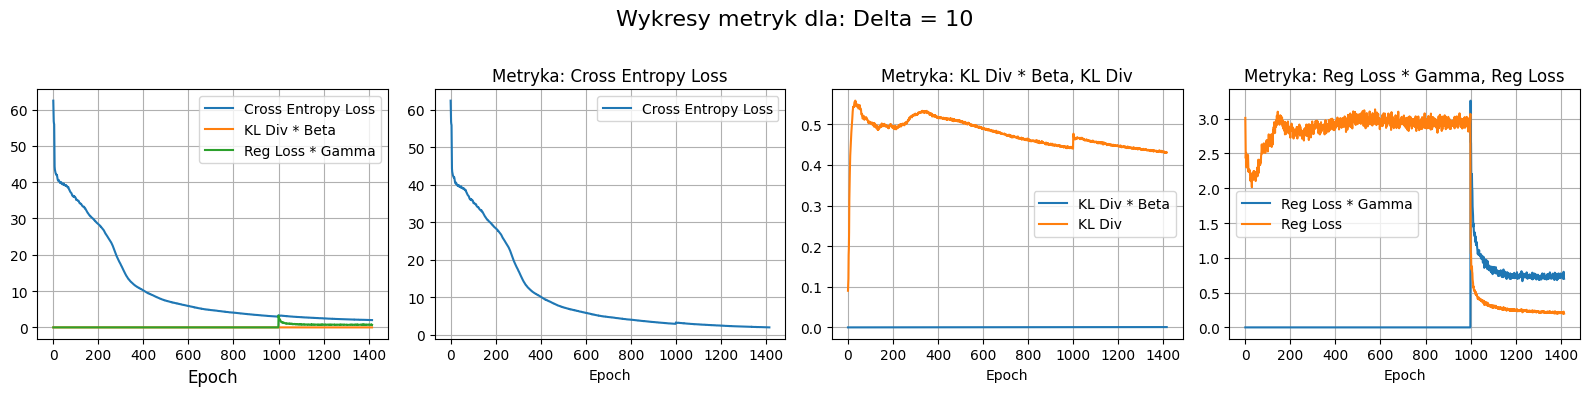

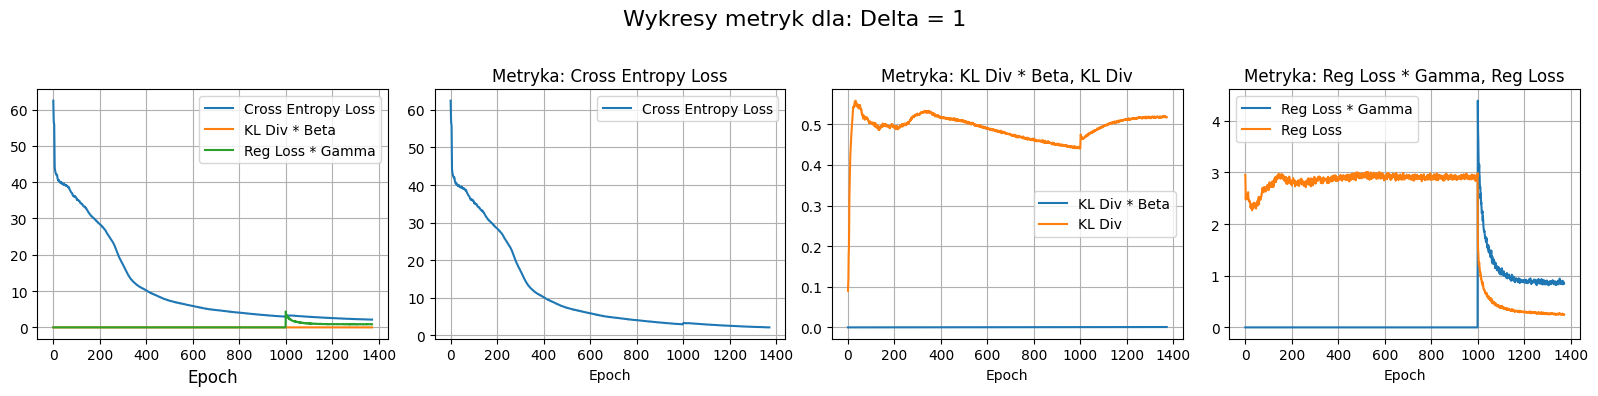

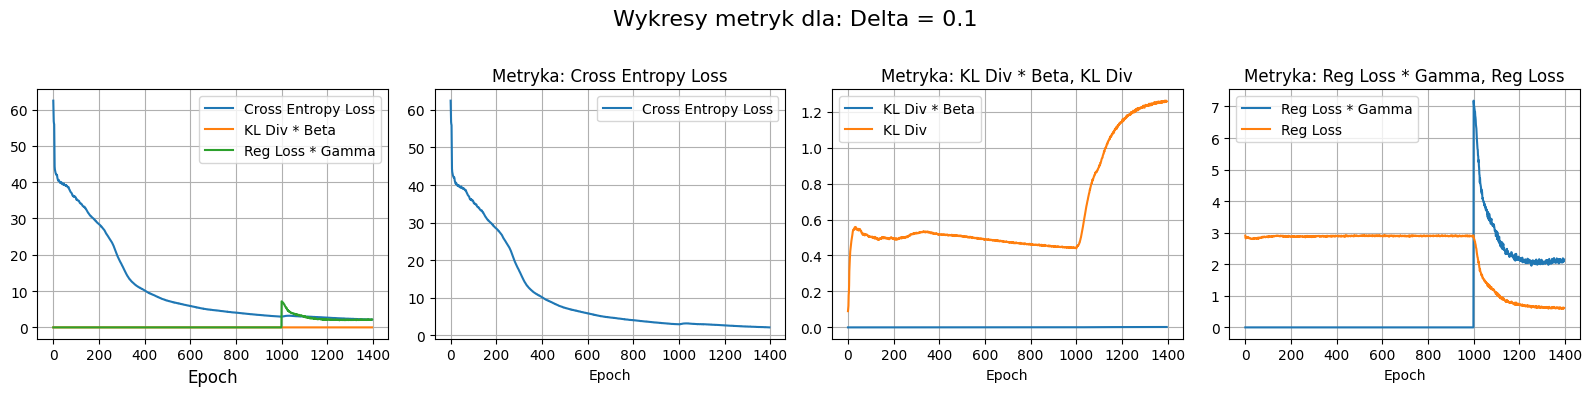

In [4]:
column_b = 'Cross Entropy Loss'
column_c1 = 'KL Div * Beta'
column_c2 = 'KL Div'
column_d1 = 'Reg Loss * Gamma'
column_d2 = 'Reg Loss'

cols_to_plot = [
    [column_b],
    [column_c1, column_c2],
    [column_d1, column_d2]
]

for file_path, title in train_file_info.items():
    try:
        df = pd.read_csv(file_path)
        df = df[df["Mode"]=="train"]
    except FileNotFoundError:
        print(f"Błąd: Plik '{file_path}' nie został znaleziony.")
        continue

    fig, axes = plt.subplots(1, 4, figsize=(16, 4), sharex=True, sharey = 'col')
    axes[0].plot(df[column_a], df[column_b]) 
    axes[0].plot(df[column_a], df[column_c1]) 
    axes[0].plot(df[column_a], df[column_d1]) 
    axes[0].set_xlabel(column_a, fontsize=12) 
    # plt.ylabel(column_2_name, fontsize=12) 
    axes[0].grid(True) 
    axes[0].legend([column_b, column_c1, column_d1])
    for i, cols in enumerate(cols_to_plot):
        ax = axes[i+1]
        
        for col_y in cols:
            ax.plot(df[column_a], df[col_y], label=col_y)
        
        ax.set_title(f"Metryka: {', '.join(cols)}")
        ax.set_xlabel(column_a)
        ax.grid(True)
        ax.legend()
        
    fig.suptitle(f"Wykresy metryk dla: {title}", fontsize=16)
    
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

## MAE for attributes tracking

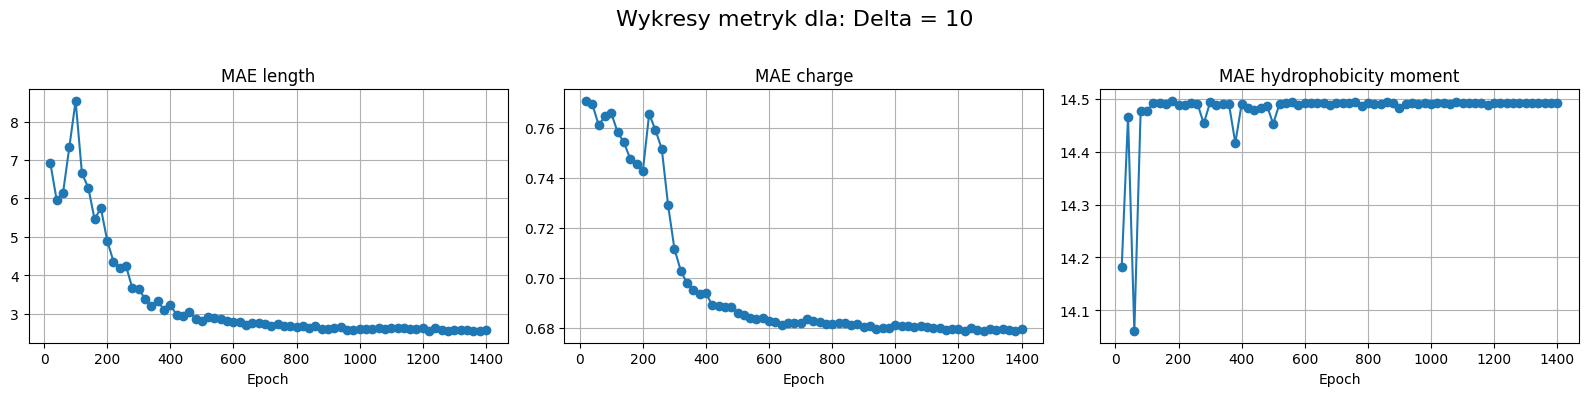

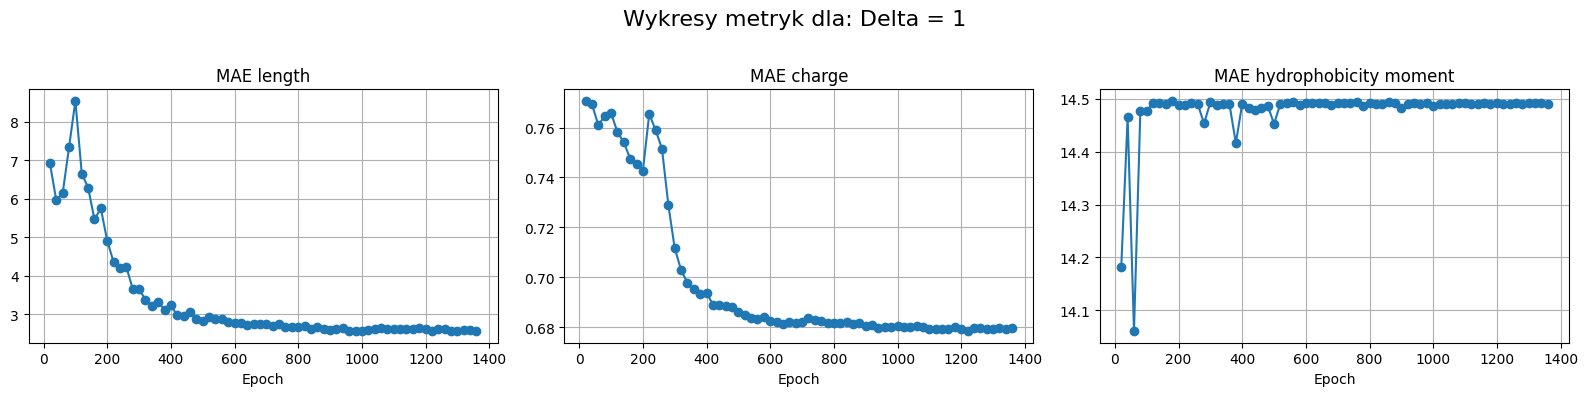

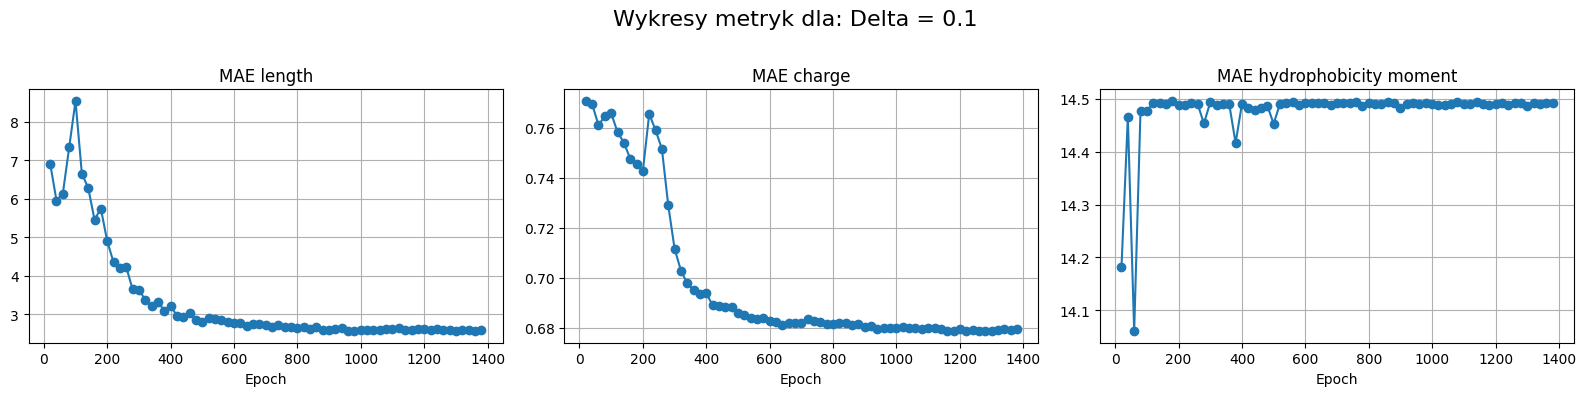

In [5]:
column_b = 'MAE length'
column_c = 'MAE charge'
column_d = 'MAE hydrophobicity moment'

cols_to_plot = [
    column_b, column_c, column_d
]

for file_path, title in val_file_info.items():
    try:
        df = read_and_fix_csv(file_path, all_expected_columns)
        
        if df is None:
            continue
        
        df = df[df["Mode"]=="test"].copy()

        df[column_a] = pd.to_numeric(df[column_a], errors='coerce')
        df.dropna(subset=[column_a], inplace=True)
        df = df.fillna(0)
        
    except FileNotFoundError:
        print(f"Błąd: Plik '{file_path}' nie został znaleziony.")
        continue
    except Exception as e:
        print(f"Wystąpił nieoczekiwany błąd podczas przetwarzania pliku '{file_path}': {e}")
        continue

    fig, axes = plt.subplots(1, 3, figsize=(16, 4), sharex=True, sharey = 'col')
    for i, col_y in enumerate(cols_to_plot):
        ax = axes[i]
        df[col_y] = pd.to_numeric(df[col_y], errors='coerce').fillna(0)
        ax.plot(df[column_a], df[col_y], marker='o', label=col_y)
        ax.set_title(f"{col_y}")
        ax.set_xlabel(column_a)
        x_min = int(df[column_a].min())
        x_max = int(df[column_a].max())
        custom_ticks = np.arange(x_min, x_max + 200, 200)
        ax.set_xticks(custom_ticks)
        ax.grid(True)
        
    fig.suptitle(f"Wykresy metryk dla: {title}", fontsize=16)
    
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

## Other training metrics tracking

Czy df1 jest równe df2? False


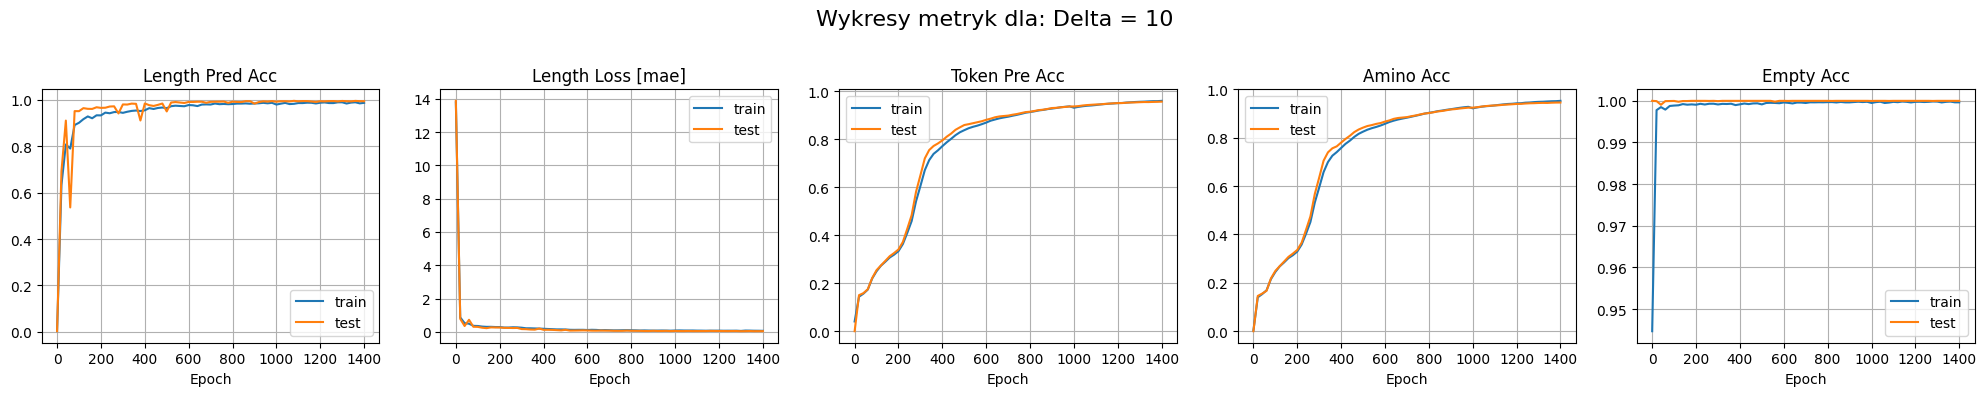

Czy df1 jest równe df2? False


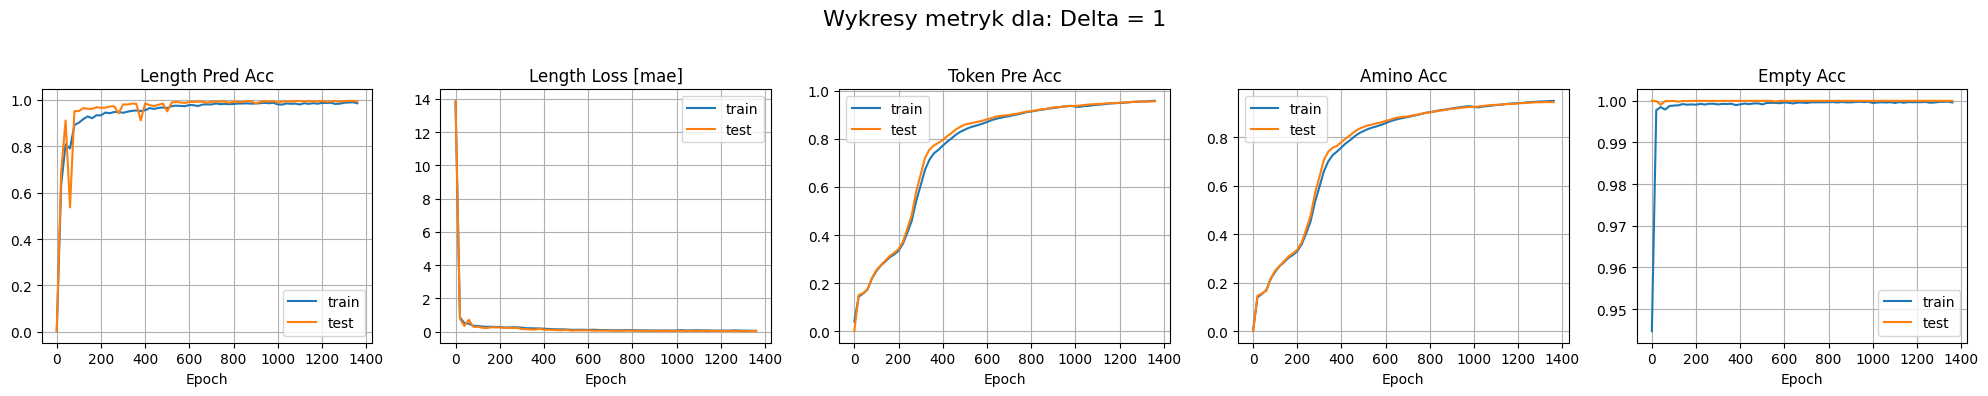

Czy df1 jest równe df2? False


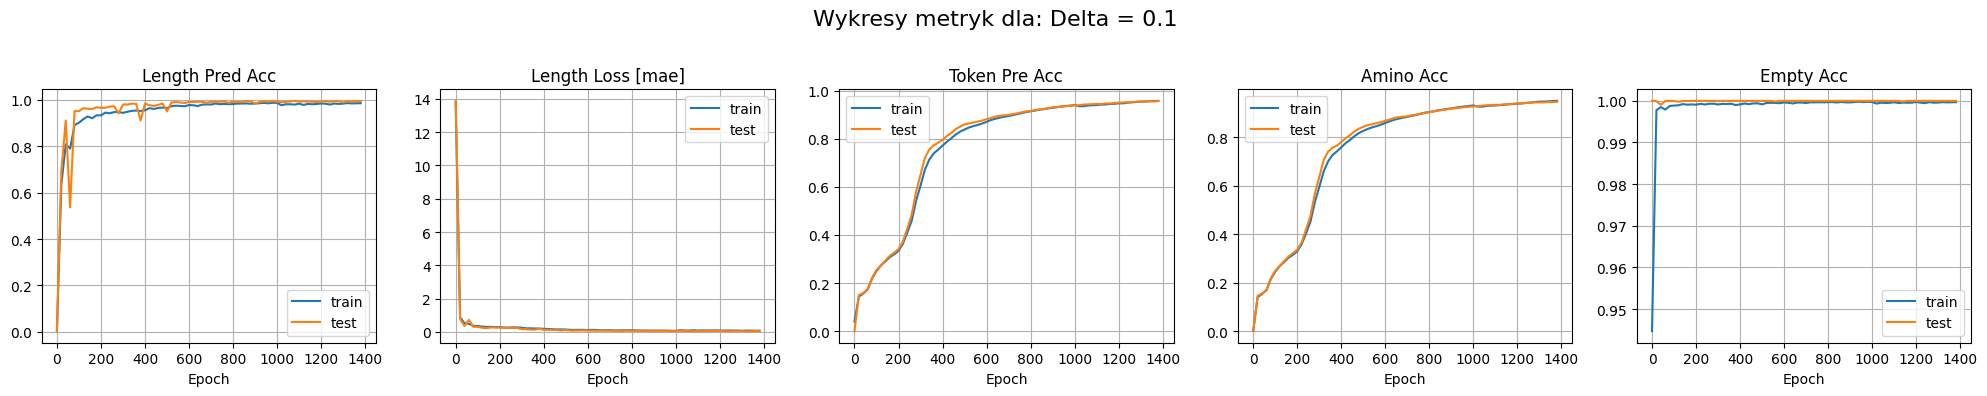

In [10]:
column_b = "Length Pred Acc"
column_c = "Length Loss [mae]"
column_d = "Token Pre Acc"
column_e = "Amino Acc"
column_f = "Empty Acc"

cols_to_plot = [
    column_b, column_c, column_d, column_e, column_f
]
df_last = pd.DataFrame()

for file_path, title in val_file_info.items():
    try:
        df = read_and_fix_csv(file_path, all_expected_columns)
        print(f"Czy df1 jest równe df2? {df.equals(df_last)}")
        df_last = df.copy()
        df_train = df[df["Mode"]=="train"].copy()   
        df_test = df[df["Mode"]=="test"].copy()

        df_train[column_a] = pd.to_numeric(df_train[column_a], errors='coerce')
        df_test[column_a] = pd.to_numeric(df_test[column_a], errors='coerce')        

        df_train.dropna(subset=[column_a], inplace=True)
        df_test.dropna(subset=[column_a], inplace=True)

        df_train = df_train.infer_objects(copy=False).fillna(0)
        df_test = df_test.infer_objects(copy=False).fillna(0)
    except FileNotFoundError:
        print(f"Błąd: Plik '{file_path}' nie został znaleziony.")
        continue
    except Exception as e:
        print(f"Wystąpił nieoczekiwany błąd podczas przetwarzania pliku '{file_path}': {e}")
        continue

    fig, axes = plt.subplots(1, 5, figsize=(20, 4), sharex=True, sharey = 'col')
    for i, col_y in enumerate(cols_to_plot):
        ax = axes[i]
        df_train[col_y] = pd.to_numeric(df_train[col_y], errors='coerce').fillna(0)
        df_test[col_y] = pd.to_numeric(df_test[col_y], errors='coerce').fillna(0)
        ax.plot(df_train[column_a], df_train[col_y], label="train")
        ax.plot(df_test[column_a], df_test[col_y], label="test")
        ax.set_title(f"{col_y}")
        ax.set_xlabel(column_a)
        x_min = int(df_train[column_a].min())
        x_max = int(df_train[column_a].max())
        custom_ticks = np.arange(x_min, x_max + 200, 200)
        ax.set_xticks(custom_ticks)
        ax.grid(True)
        ax.legend()
        
    fig.suptitle(f"Wykresy metryk dla: {title}", fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()    

## AR-VAE Metrics

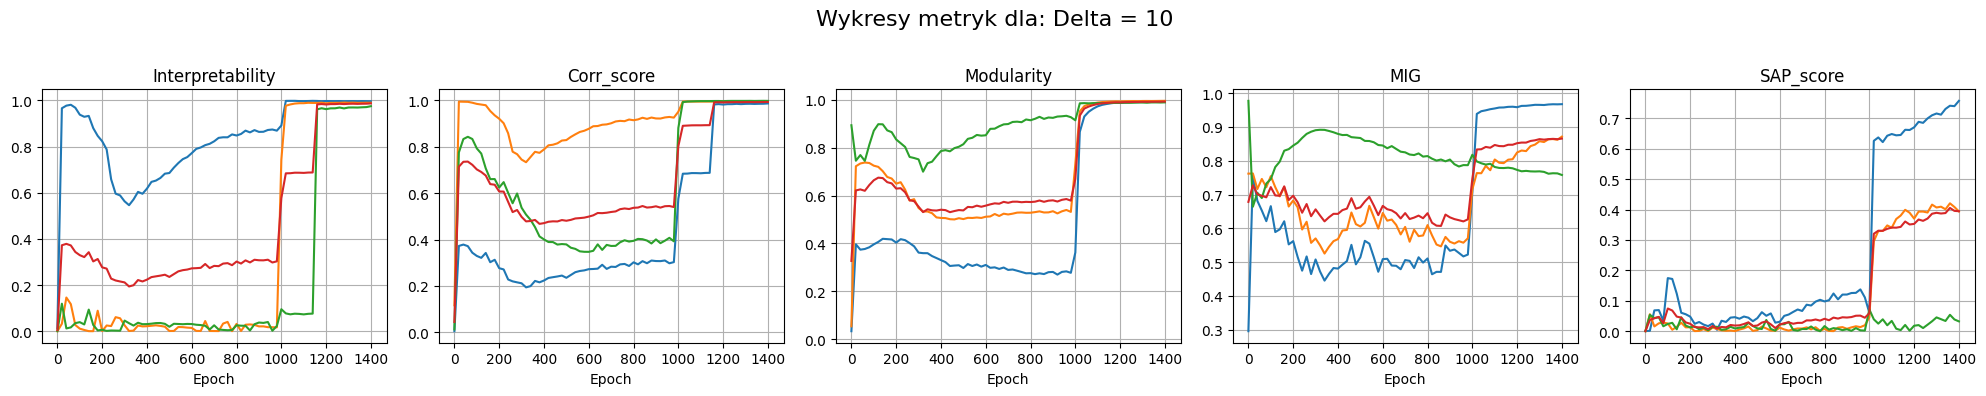

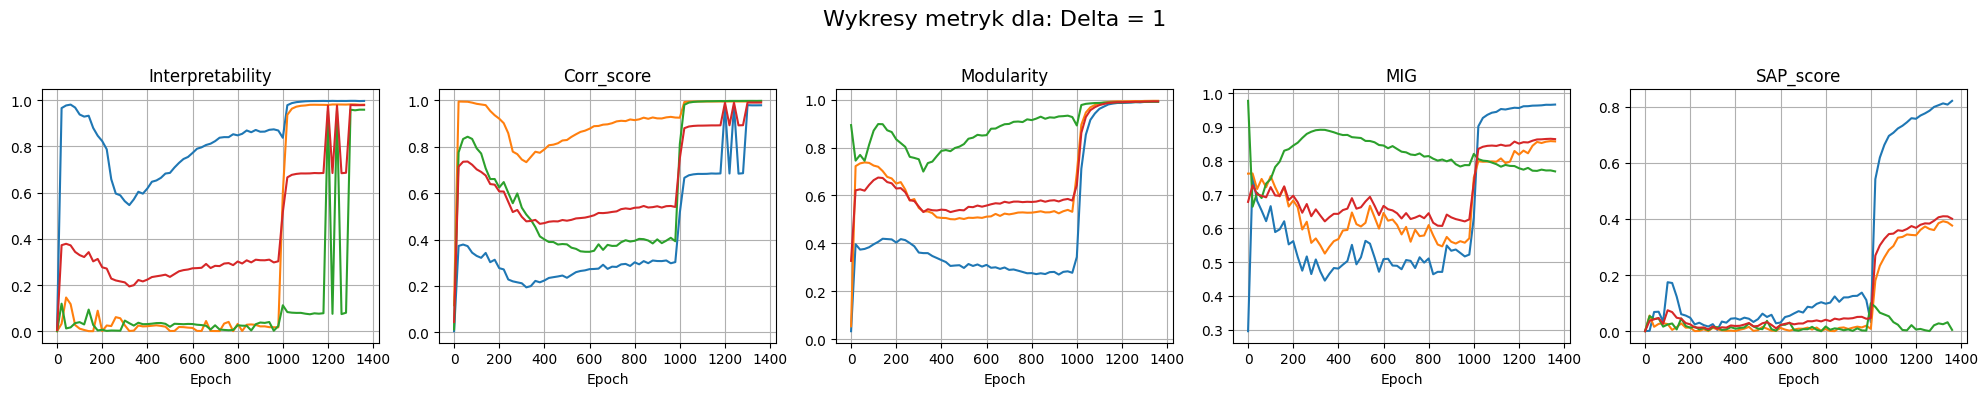

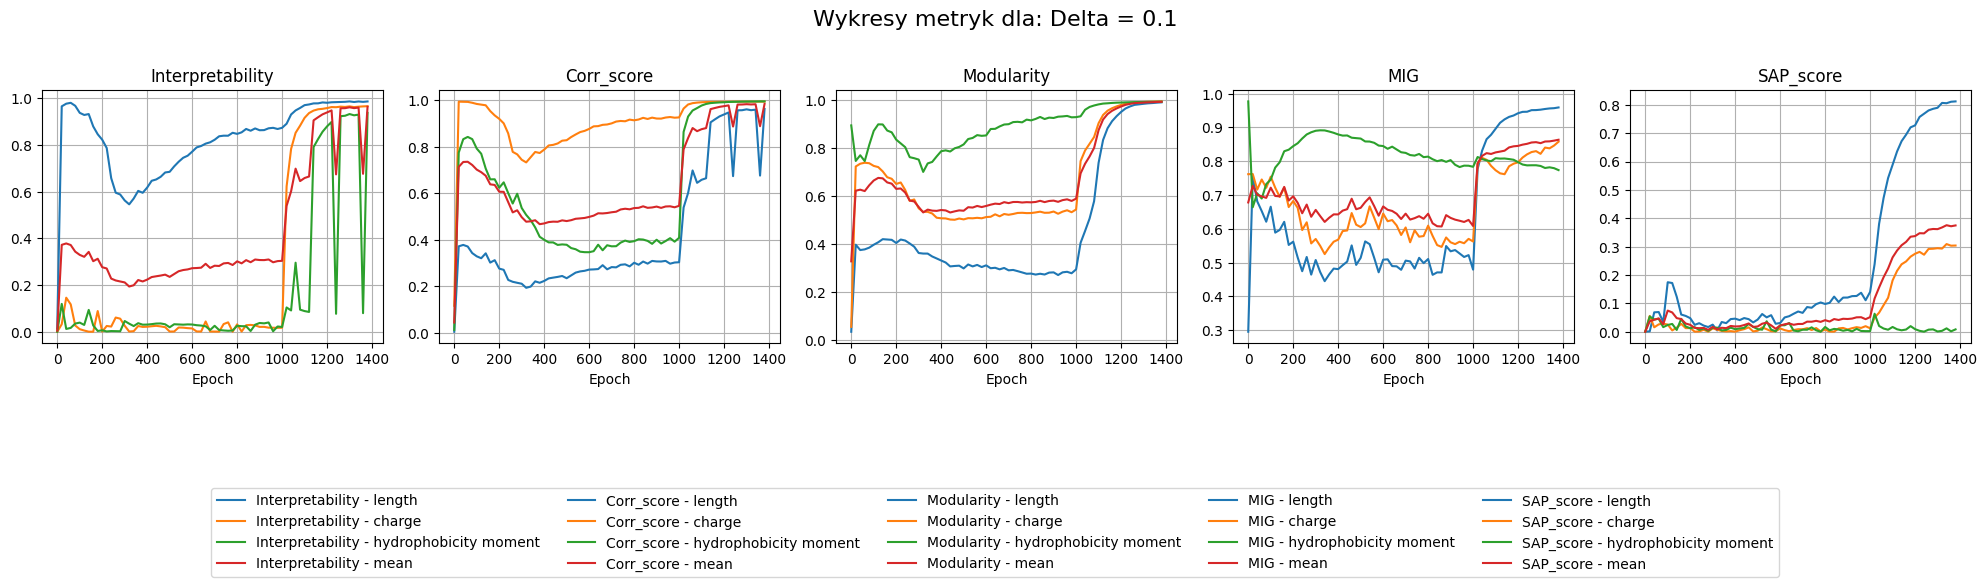

In [11]:
column_b1 = "Interpretability - length"
column_b2 = "Interpretability - charge"
column_b3 = "Interpretability - hydrophobicity moment"

column_c1 = "Corr_score - length"
column_c2 = "Corr_score - charge"
column_c3 = "Corr_score - hydrophobicity moment"

column_d1 = "Modularity - length"
column_d2 = "Modularity - charge"
column_d3 = "Modularity - hydrophobicity moment"

column_e1 = "MIG - length"
column_e2 = "MIG - charge"
column_e3 = "MIG - hydrophobicity moment"

column_f1 = "SAP_score - length"
column_f2 = "SAP_score - charge"
column_f3 = "SAP_score - hydrophobicity moment"

cols_to_plot = [
    [column_b1, column_b2, column_b3], 
    [column_c1, column_c2, column_c3], 
    [column_d1, column_d2, column_d3], 
    [column_e1, column_e2, column_e3], 
    [column_f1, column_f2, column_f3]
]

for file_path, title in val_file_info.items():
    try:
        df = read_and_fix_csv(file_path, all_expected_columns)
        
        df = df[df["Mode"]=="test"].copy()
        df[column_a] = pd.to_numeric(df[column_a], errors='coerce')   
        df.dropna(subset=[column_a], inplace=True)
        df = df.infer_objects(copy=False).fillna(0)
    except FileNotFoundError:
        print(f"Błąd: Plik '{file_path}' nie został znaleziony.")
        continue
    except Exception as e:
        print(f"Wystąpił nieoczekiwany błąd podczas przetwarzania pliku '{file_path}': {e}")
        continue

    if title == 'Delta = 0.1':
        fig, axes = plt.subplots(1, 5, figsize=(20, 4), sharex=True, sharey = 'col')
    else:
        fig, axes = plt.subplots(1, 5, figsize=(20, 4), sharex=True, sharey = 'col')
    for i, cols in enumerate(cols_to_plot):
        ax = axes[i]
        for col_y in cols:
            df[col_y] = pd.to_numeric(df[col_y], errors='coerce').fillna(0)
            ax.plot(df[column_a], df[col_y], label=col_y)
        df['mean'] = df[cols].mean(axis=1)
        ax.plot(df[column_a], df['mean'], label=col_y.split(' - ')[0] + ' - mean')
        ax.set_title(f"{col_y.split(' - ')[0]}")
        ax.set_xlabel(column_a)
        x_min = int(df[column_a].min())
        x_max = int(df[column_a].max())
        custom_ticks = np.arange(x_min, x_max + 200, 200)
        ax.set_xticks(custom_ticks)
        ax.grid(True)
    if title == 'Delta = 0.1':
        fig.legend(bbox_to_anchor=(0.5, -0.2), loc='upper center', ncol=5)
        
    fig.suptitle(f"Wykresy metryk dla: {title}", fontsize=16)
    
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

## Latent visualization

In [96]:
result_files = find_and_group_model_files(models_prefixs_to_compare)
matching_epochs = find_files_with_matching_epochs(result_files)
filtered_models = {}
for epoch_key in matching_epochs.keys():
    matching_flg = True
    if len(matching_epochs[epoch_key].keys()) != len(models_prefixs_to_compare):
        matching_flg = False
    else:    
        for models_key in matching_epochs[epoch_key]:
            if matching_epochs[epoch_key][models_key] == '':
                matching_flg = False
    if matching_flg:
        filtered[epoch_key] = matching_epochs[epoch_key]
filtered_models

{100: {'hyperparams_tuning_ar-vae_epoch': {'_encoder': 'hyperparams_tuning_ar-vae_epoch100_encoder.pt',
   '_decoder': 'hyperparams_tuning_ar-vae_epoch100_decoder.pt'},
  'hyperparams_tuning_factor_10_ar-vae_epoch': {'_encoder': 'hyperparams_tuning_factor_10_ar-vae_epoch100_encoder.pt',
   '_decoder': 'hyperparams_tuning_factor_10_ar-vae_epoch100_decoder.pt'},
  'hyperparams_tuning_factor_1_ar-vae_epoch': {'_encoder': 'hyperparams_tuning_factor_1_ar-vae_epoch100_encoder.pt',
   '_decoder': 'hyperparams_tuning_factor_1_ar-vae_epoch100_decoder.pt'}}}

In [ ]:
import torch
import os
from torch import nn, cuda, backends, manual_seed, tensor
from torch.utils.data import TensorDataset, DataLoader, random_split
from torch.autograd import Variable
from model.model import EncoderRNN, DecoderRNN
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import random
from pathlib import Path
from tqdm import tqdm
import data.dataset as dataset_lib
from model.constants import MIN_LENGTH, MAX_LENGTH
import ar_vae_metrics as m
from scipy import stats
import torch
import os
from torch import optim, nn, logsumexp, cuda, save, backends, manual_seed, LongTensor, zeros_like, ones_like, tensor, cat
from torch.distributions import Normal
from torch.utils.data import TensorDataset, DataLoader, random_split
torch.autograd.set_detect_anomaly(True)
from model.model import EncoderRNN, DecoderRNN
import numpy as np
import clearml
from typing import Optional, Literal
from torch.optim import Adam
import itertools
import random
import seaborn as sns
from pathlib import Path
from tqdm import tqdm
import data.dataset as dataset_lib
from model.constants import MIN_LENGTH, MAX_LENGTH, VOCAB_SIZE
import ar_vae_metrics as m
import monitoring as mn
import regularization as r
from sklearn.decomposition import IncrementalPCA
import pandas as pd

In [ ]:
    global ROOT_DIR 
    ROOT_DIR = Path().resolve()
    DATA_DIR = ROOT_DIR / "data"
    global MODELS_DIR 
    MODELS_DIR = ROOT_DIR
    params = {
        "num_heads": 4,
        "num_layers": 6,
        "layer_norm": True,
        "latent_dim": 56,
        "encoding": "add",
        "dropout": 0.1,
        
        "batch_size": 512
        # "lr": 0.001,
        # "train_size": None,
        # "iwae_samples": 10,
        # "model_name": os.getenv("CLEARML_PROJECT_NAME", 'ar-vae-v4'),
        # "use_clearml": True,
        # "task_name": os.getenv("CLEARML_TASK_NAME", "ar-vae 3 dims"),
        # "device": "cuda",
        # "deeper_eval_every": 20,
        # "save_model_every": 20,
        # "ar_vae_flg": False,
        # "reg_dim": [0,1,2], # [length, charge, hydrophobicity_moment]
    }
    encoder_iwae = EncoderRNN(
        params["num_heads"],
        params["num_layers"],
        params["latent_dim"],
        params["encoding"],
        params["dropout"],
        params["layer_norm"],
    )
    decoder_iwae = DecoderRNN(
        params["num_heads"],
        params["num_layers"],
        params["latent_dim"],
        params["encoding"],
        params["dropout"],
        params["layer_norm"],
    )
    encoder_arvae = EncoderRNN(
        params["num_heads"],
        params["num_layers"],
        params["latent_dim"],
        params["encoding"],
        params["dropout"],
        params["layer_norm"],
    )
    decoder_arvae = DecoderRNN(
        params["num_heads"],
        params["num_layers"],
        params["latent_dim"],
        params["encoding"],
        params["dropout"],
        params["layer_norm"],
    )
    attr_dict = {
        'Length': 0, 
        'Charge': 1, 
        'Hydrophobicity moment': 2
    }

In [ ]:
    DEVICE = torch.device(f'cuda:{cuda.current_device()}' if cuda.is_available() else 'cpu')
    is_cpu = False if torch.cuda.is_available() else True
    encoder_iwae_filepath = os.path.join(
        os.sep, "home","gwiazale", "AR-VAE",
        "first_working_models","iwae_continue_training_ar-vae-v4_epoch880_encoder.pt"
    )
    decoder_iwae_filepath = os.path.join(
        os.sep, "home","gwiazale", "AR-VAE",
        "first_working_models","iwae_continue_training_ar-vae-v4_epoch880_decoder.pt"
    )
    encoder_arvae_filepath = os.path.join(
        os.sep, "home","gwiazale", "AR-VAE",
        "first_working_models","ar_vae_continue_training_ar-vae-v4_epoch940_encoder.pt"
    )
    decoder_arvae_filepath = os.path.join(
        os.sep, "home","gwiazale", "AR-VAE",
        "first_working_models","ar_vae_continue_training_ar-vae-v4_epoch940_decoder.pt"
    )
    if is_cpu:
        encoder_iwae.load_state_dict(
            torch.load(
                encoder_iwae_filepath,
                map_location=DEVICE
            )
        )
        decoder_iwae.load_state_dict(
            torch.load(
                decoder_iwae_filepath,
                map_location=DEVICE
            )
        )
        encoder_arvae.load_state_dict(
            torch.load(
                encoder_arvae_filepath,
                map_location=DEVICE
            )
        )
        decoder_arvae.load_state_dict(
            torch.load(
                decoder_iwae_filepath,
                map_location=DEVICE
            )
        )
    else:
        encoder_iwae.load_state_dict(torch.load(encoder_iwae_filepath))
        decoder_iwae.load_state_dict(torch.load(decoder_iwae_filepath))
        encoder_arvae.load_state_dict(torch.load(encoder_arvae_filepath))
        decoder_arvae.load_state_dict(torch.load(decoder_arvae_filepath))
    encoder_iwae = encoder_iwae.to(DEVICE)
    decoder_iwae = decoder_iwae.to(DEVICE)
    encoder_arvae = encoder_arvae.to(DEVICE)
    decoder_arvae = decoder_arvae.to(DEVICE)


In [ ]:
    data_manager = dataset_lib.AMPDataManager(
        DATA_DIR / 'unlabelled_positive.csv',
        DATA_DIR / 'unlabelled_negative.csv',
        min_len=MIN_LENGTH,
        max_len=MAX_LENGTH)

    amp_x, amp_y, attributes_input, _ = data_manager.get_merged_data()
    # attributes = dataset_lib.normalize_attributes(attributes_input)    
    dataset = TensorDataset(amp_x, tensor(amp_y), attributes_input, attributes_input)
    train_size = int(0.8 * len(dataset))
    eval_size = len(dataset) - train_size

    train_dataset, eval_dataset = random_split(dataset, [train_size, eval_size])
    train_loader = DataLoader(train_dataset, batch_size=params["batch_size"], shuffle=True)
    eval_loader = DataLoader(eval_dataset, batch_size=params["batch_size"], shuffle=True)

In [ ]:
    attr_dims = [attr_dict[attr] for attr in attr_dict.keys()]
    non_attr_dims = [a for a in range(params['latent_dim']) if a not in attr_dims]
    for non_attr_dim in non_attr_dims:
        if non_attr_dim == 40:
            plot_latent_surface(
                    train_loader,
                    filtered_models,
                    dim1=attr_dims,
                    dim2=non_attr_dim,
                    grid_res=0.15,
                    z_dim = params["latent_dim"]
            )